# Cleaning Amazon Product Metadata

This notebook processes and cleans the Amazon product metadata dataset.  
The main focus is on imputing missing values in the product ranking and category columns, and cleaning other key features.

**Workflow:**
1. **Data Import:**  
   - Loads raw metadata and selects relevant columns.

2. **Rank Extraction and Cleaning:**  
   - Parses the `rank` column into structured dictionaries.
   - Focuses on extracting and imputing the 'Toys & Games' rank for each product.

3. **Imputation of Missing Ranks:**  
   - Uses K-Nearest Neighbors regression to predict missing 'Toys & Games' ranks based on overlap with other categories.
   - For remaining missing values, imputes using the geometric mean of ranks from similar products (`also_buy` and `also_view`).

4. **Category Cleaning:**  
   - Extracts and imputes missing top-level categories using information from similar products.

5. **Other Feature Cleaning:**  
   - Cleans the `price` column and creates a `missing_price` indicator.
   - Drops unnecessary columns and duplicate rows.

6. **Export:**  
   - Saves the cleaned metadata to a Parquet file for further use.

**Outputs:**  
- A cleaned metadata DataFrame with imputed ranks and categories, ready for modeling.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
tqdm.pandas()

In [2]:
import sys
from pathlib import Path

project_root = Path().resolve().parent   
sys.path.insert(0, str(project_root / "src"))

In [3]:
# Import the metadata. We'll only import the columns we need.

meta_df=pd.read_pickle("../Data/metadata_raw.pkl")

In [4]:
meta_df.head(5)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Toys & Games, Puzzles, Jigsaw Puzzles]",,"[Three Dr. Suess' Puzzles: Green Eggs and Ham,...",,Dr. Suess 19163 Dr. Seuss Puzzle 3 Pack Bundle,[],,Dr. Seuss,"[Three giant floor puzzles, Includes: Dr. Sues...","[>#2,230,717 in Toys & Games (See Top 100 in T...",[],Toys & Games,,,,0000191639,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,[],,[<b>Prepare to be Afraid!</b><br /><br />The B...,,Pathfinder: Book of Beasts - Legendary Foes,[],,Pathfinder Roleplaying Jon Brazer Productions,[],"[>#2,294,535 in Toys & Games (See Top 100 in T...",[],Toys & Games,,,.a-box-inner{background-color:#fff}#alohaBuyBo...,0004950763,[],[],NaN
2,[],,[],,Nursery Rhymes Felt Book,[],,Betty Lukens,[],"[>#2,871,983 in Toys & Games (See Top 100 in T...",[],Toys & Games,,,.a-box-inner{background-color:#fff}#alohaBuyBo...,0005069491,[],[],NaN
3,"[Toys & Games, Games, Card Games]",,[Blitz Vintage Card Game],,Dutch Blitz Card Game,[B00WIIPQEC],,Dutch Blitz Games Co,[],"[>#376,337 in Toys & Games (See Top 100 in Toy...","[B000BBU0KS, B00NQQTZ5G, B00WIIPQEC, B001VIWAO...",Toys & Games,"class=""a-bordered a-horizontal-stripes a-spa...",,$24.95,0004983289,[],[],NaN
4,[],,"[Marvel SuperHeroes themed ""magic ink"" colorin...",,Magic Pen Painting (Marvel Super Heroes),"[B009SB7TI8, B009SB8Z1I]",,Lee Publications,[],"[>#934,954 in Toys & Games (See Top 100 in Toy...",[],Toys & Games,,,$4.92,0006466222,[],[],NaN


Many of these columns don't seem to contain useful data for our project, either because the data is irrelevant, or there are too many missing values. Thereforefore, many columns will be dropped.

In [5]:
columns=['asin','category', 'title', 'price','also_buy', 'also_view','rank']
meta_df=meta_df[columns]

In [6]:
meta_df[meta_df['rank'].apply(lambda x: type(x)==str)]

,asin,category,title,price,also_buy,also_view,rank
42,0547775520,"[Toys & Games, Learning & Education, Science, ...",Focus on California Science Exam View Test Ban...,,[],[],"56,123 in Software ("
313,0979818214,"[Toys & Games, Games, Standard Playing Card De...",Shakespeare &quot;Insults&quot; Playing Cards,$13.74,"[0979818206, 1452127751, B00H5E36DW, 045153398...",[],"22,195 in Sports & Outdoors ("
314,0979818206,"[Toys & Games, Games, Standard Playing Card De...",Shakespeare &quot;Quotes&quot; Playing Cards,$10.68,"[0979818214, 0451533984, 1452162476, B00MYB8X0...",[],"78,465 in Sports & Outdoors ("
331,0982123272,"[Toys & Games, Games, Standard Playing Card De...",Jane Austen Playing Cards &quot;Gold Back&quot;,$9.25,"[B00KSERAQA, B01BWWOXSE, 0736965181, B00H5E345...",[],"160,397 in Sports & Outdoors ("
332,0982123299,"[Toys & Games, Games, Standard Playing Card De...",Jane Austen Playing Cards &quot;Copper Back&quot;,$9.25,"[1608423506, B00MH43KK4, B00KSERAQA, 048629785...",[],"193,026 in Sports & Outdoors ("
...,...,...,...,...,...,...,...
633786,B01HIXLVWM,"[Toys & Games, Games, Standard Playing Card De...",Giant Faces Ace Authentic Limited Edition Play...,$20.00,"[B00EILD36A, B003L90Z1Q, B000VKYIOI]","[B003L90Z1Q, B075TF75RB, B0087IYE4K, B00EILD36...","233,813 in Sports & Outdoors ("
633787,B01HIXPC0E,"[Toys & Games, Novelty & Gag Toys, Miniatures]",US Toy Assorted Color and Design Tropical Fish...,$6.52,"[B00362TS98, B01KN0L3O8, B00IA41NUY, B001BL897...",[],"106,544 in Toys & Games ("
633797,B01HIXPE48,"[Toys & Games, Action Figures & Statues, Actio...",US Toy Mini Horses Action Figure (2-Pack of 12),$8.27,"[B003O6PYI0, B00HM1HDXW, B0016KVKB6, B01BJ8CJM...","[B01F5SE1II, B01N7B2GHG, B002I5I192, B07GDK5HB...","220,107 in Health & Household ("
633812,B01HIZFAPO,"[Toys & Games, Dress Up & Pretend Play, Beauty...",U.S. Toy JA129 Jesus Loves Me Bracelets,$4.52,"[B003ECWM0W, B005JST5AY, B0074CEIP0, B007F0ZIQ...",[],"109,325 in Toys & Games ("


We first define the ``extract_rank_dict`` function that processes the ``rank`` column of ``meta_df``.
Here are a sample of entries from this column.

In [7]:
meta_df['rank'].iloc[[0,1,2,42,1008]]

0       [>#2,230,717 in Toys & Games (See Top 100 in T...
1       [>#2,294,535 in Toys & Games (See Top 100 in T...
2       [>#2,871,983 in Toys & Games (See Top 100 in T...
42                                   56,123 in Software (
1008                 372,303 in Industrial & Scientific (
Name: rank, dtype: object

The 4th and 5th items displayed above possible have malformed `rank` data. 

The `extract_rank_dict` function converts these into python ``dict``s, whose keys consist of the category name, and whose values are the rank.

We apply this function to the rank column.

In [8]:
from cleaning_functions import extract_rank_dict
meta_df['rank_dict']=meta_df['rank'].apply(extract_rank_dict)

The ranks in different (sub)categories are not directly comparable. For example, consider the following entry.

In [9]:
meta_df[['title','rank_dict']].iloc[5]

title        Dungeons &amp; Dragons - &quot;Storm Kings Thu...
rank_dict    {'Toys & Games': 178217, 'Toys & Games > Grown...
Name: 5, dtype: object

This item has 3 rankings in different categories. The first ranking in the 'Toys & Games' category can be directly compared with the ranking of any other item that also has such a ranking, which consists of most entries in our dataframe.

However, the 'Toys & Games > Grown-Up Toys > Games' ranking of 284 can only be compared to other items with a ranking in this subcategory, a very small proportion of the dataset.

Therefore, we first focus on the entries that have a rank in the 'Toys & Games' category.

In [10]:
# We mark entries that contain a 'Toys & Games' rank.
from cleaning_functions import contains_tg
meta_df['contains_tg']=meta_df.rank_dict.apply(contains_tg)

In [11]:
# We assign the 'Toys & Games' rank for each item where that rank exists.
meta_df['item_rank']=meta_df[meta_df.contains_tg].rank_dict.apply(
    lambda x: x['Toys & Games'])

In [12]:
# The percentage of values that now have a 'Toys & Games' rank
meta_df[meta_df.item_rank.notna()].shape[0]/meta_df.shape[0]*100

90.03317646947465

We now fill in as many of the missing values as we can. To do this, we predict a 'Toys & Games' ranking of a product based on its ranking in another category, using K-Nearest Neighbors regression trained on overlapping entries.

In [13]:
# Explode rank_dict into a long DataFrame
records = []
for idx, row in meta_df.iterrows():
    rank_dict = row.rank_dict
    if isinstance(rank_dict, dict):
        for cat, rank in rank_dict.items():
            records.append((cat, idx, rank, row.contains_tg))

cat_df = pd.DataFrame(records, columns=['category', 'index', 'rank', 'tg'])

# Group by category and aggregate lists for index, rank, tg
categories = (
    cat_df.groupby('category')
    .agg({'index': list, 'rank': list, 'tg': list})
)

# Convert each row to a DataFrame
categories['df'] = categories.apply(lambda x: pd.DataFrame({'index': x['index'], 'rank': x['rank'], 'tg': x['tg']}), axis=1)

# Add the size of each category (number of entries)
categories['size'] = categories['index'].apply(len)

# Add the number of entries in each category that have a 'Toys & Games' rank
categories['num_tgs'] = categories['tg'].apply(lambda tg_list: sum(tg_list))

# Keep only the required columns and convert to DataFrame with category as index
categories = categories[['df', 'size', 'num_tgs']]

In [14]:
from cleaning_functions import max_intersect_category
meta_df['max_intersect']=meta_df[meta_df.contains_tg==0].rank_dict.progress_apply(lambda x : max_intersect_category(x,categories))

100%|██████████| 63178/63178 [00:15<00:00, 3955.90it/s]


We illustrate the procedure with the following item.

In [15]:
meta_df[['title','rank_dict','max_intersect']].iloc[24]

title            Little Red Tool Box: Alphabet Letters &amp; Pi...
rank_dict        {'Office Products': 262028, 'Toys & Games > Le...
max_intersect    (106438, Toys & Games > Preschool > Pre-Kinder...
Name: 24, dtype: object

This "Little Red Tool Box" item has three rankings, but none of them are in the `Toys & Games` category. Nonetheless we can predict 'Toys & Games' ranking as follows. 

We first note that there are 106438 items in the dataset that contain both a `Toys & Games` rank and a `Toys & Games > Preschool > Pre-Kindergarten Toys` rank. This data is contained in the ``max_intersection'' field.

Below, we show a scatter plot of the 'Toys & Games' rank versus the 'Toys & Games > Preschool > Pre-Kindergarten Toys' rank, for all items that have both ranks. Using the k-nearest neighbours model trained in these items, we can predict a ranking of `535300` for the "Little Red Tool Box".

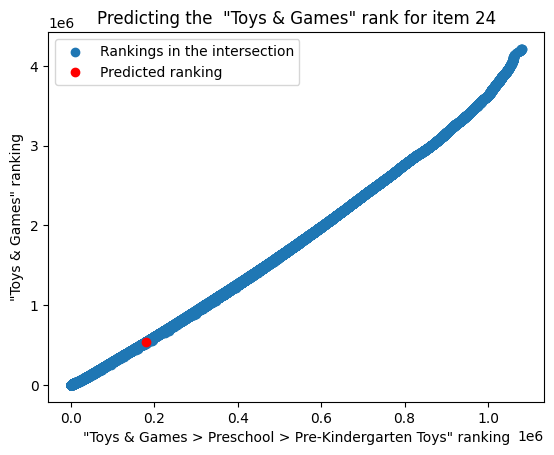

In [16]:
i=24
row = meta_df.iloc[i]
key = row.max_intersect[1]
merge=categories.loc[key].df.merge(categories.loc['Toys & Games'].df,on='index')
plt.scatter(merge.rank_x,merge.rank_y,label='Rankings in the intersection')

from cleaning_functions import predict_rank
#
x=row.rank_dict[key]
y=predict_rank(row,categories)
plt.plot(x,y,'ro',label='Predicted ranking')
plt.legend()
plt.xlabel(f'"{key}" ranking')
plt.ylabel('"Toys & Games" ranking')
plt.title(f'Predicting the  "Toys & Games" rank for item {i}')
plt.show()

Despite, the shape of the graph, it is not the case that the `Toys & Games` rank is a strictly increasing function of the  the `Toys & Games > Preschool > Pre-Kindergarten Toys` rank. However, this appears to be approximately true, justifying our approach for imputing missing ranks. (We expect the reason the function is not strictly increasing is because the rankings are generated at slightly different times on constantly changing data.)

Below, we plot six additonal such graphs for a random sample of 6 items with missing data.

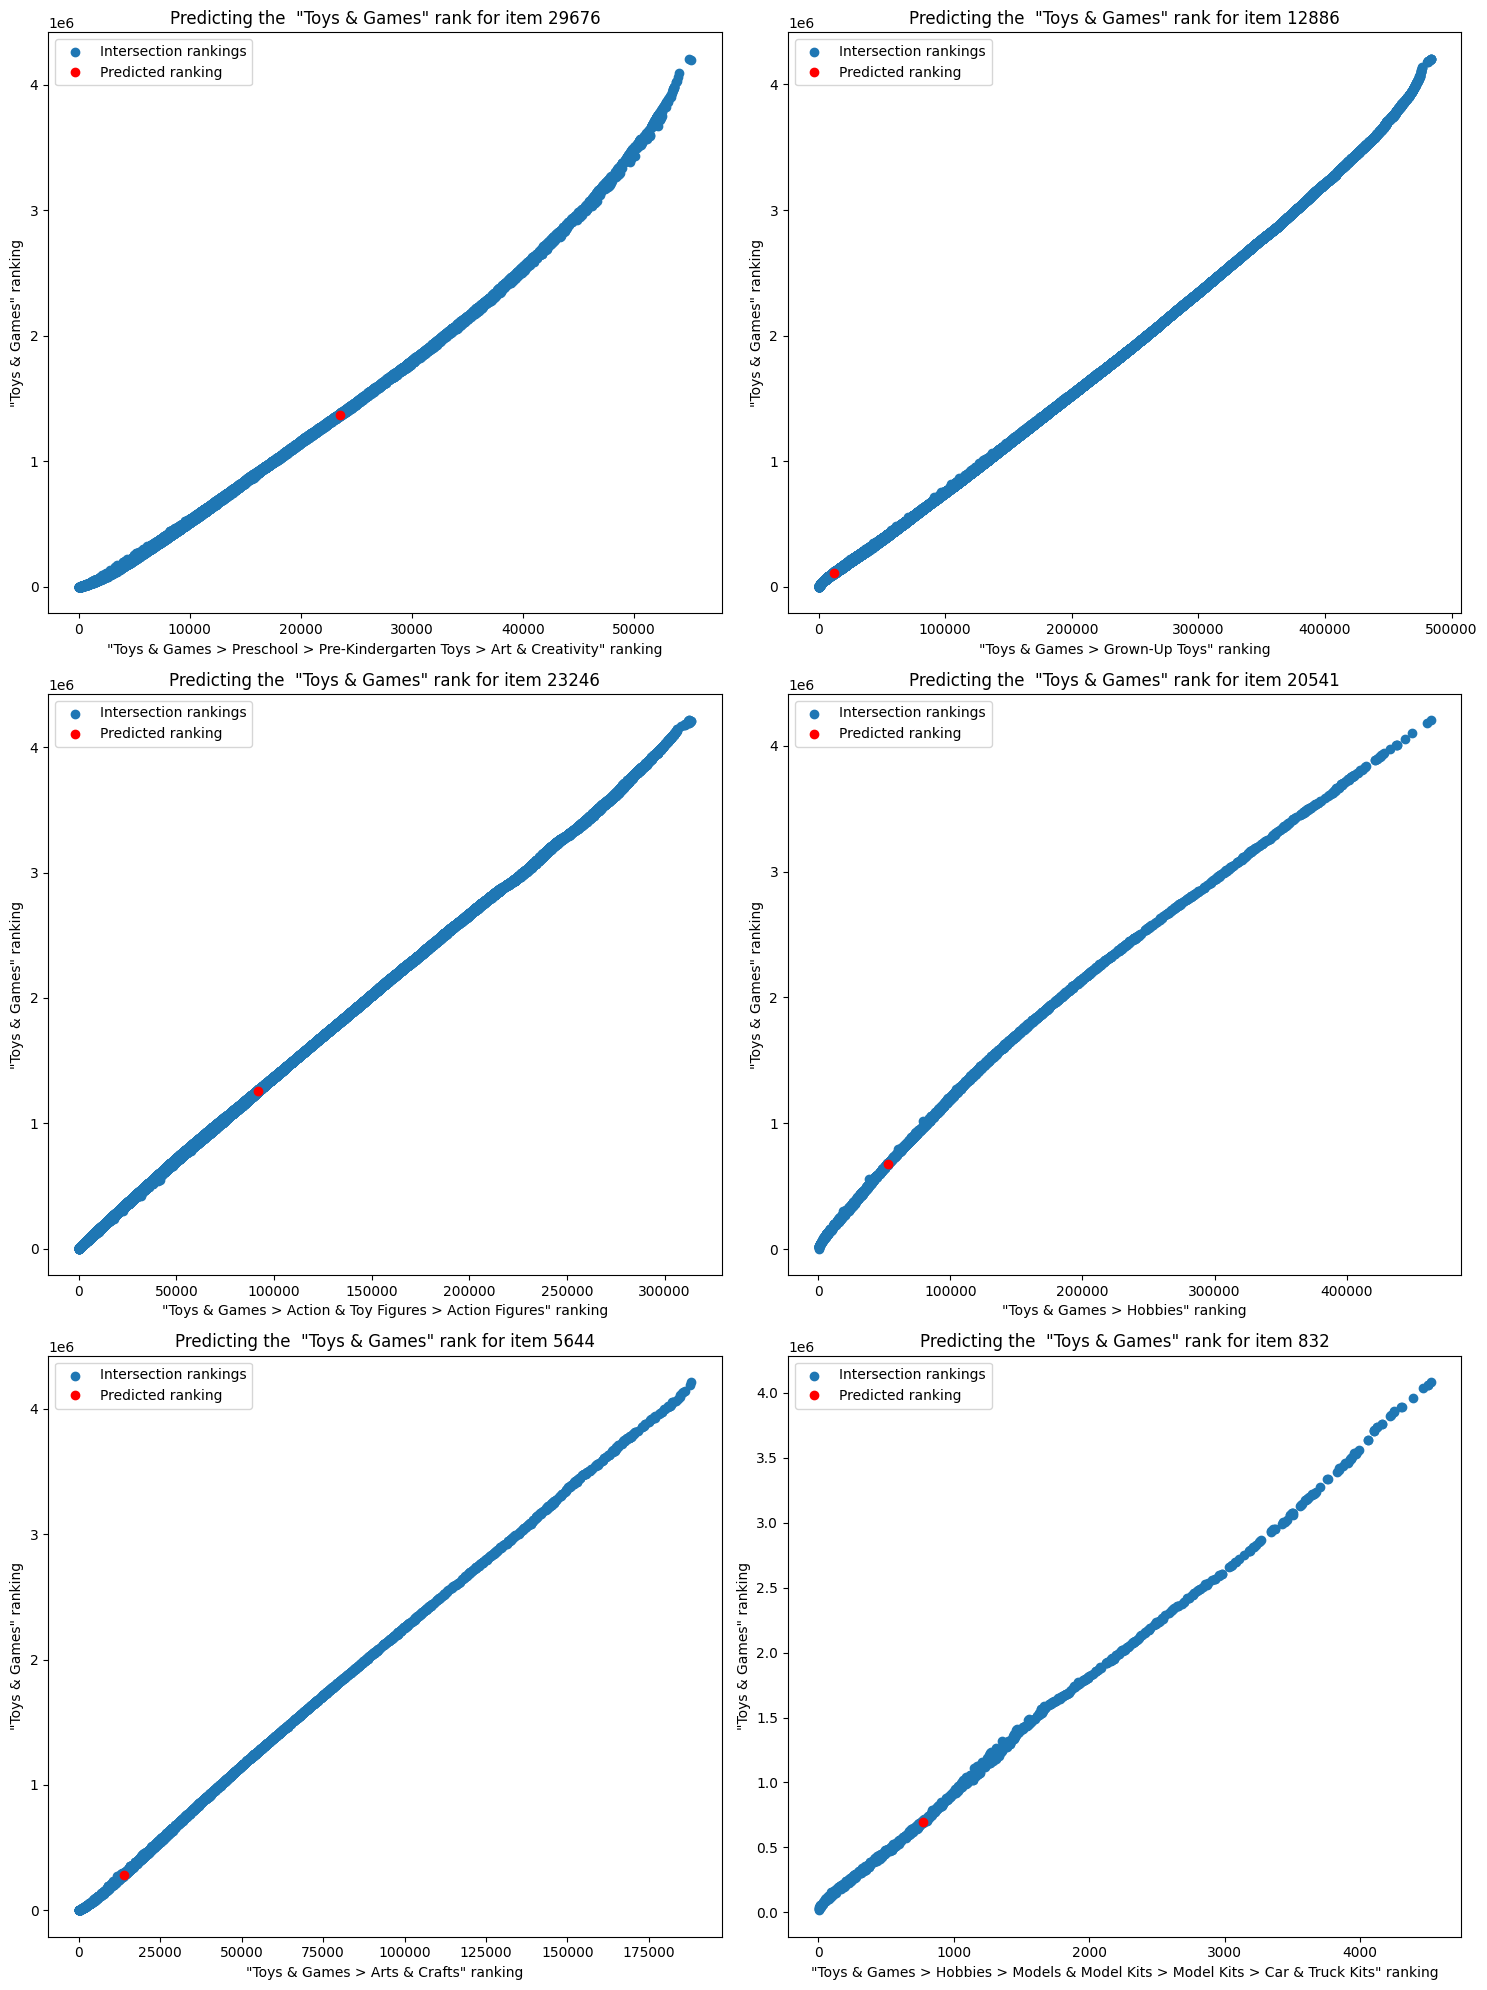

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20))  
axes = axes.flatten()

predictable_rows=meta_df[meta_df.max_intersect.notna()]
predictable_rows=predictable_rows[predictable_rows.max_intersect.apply(lambda x: x[0]>10)]
rng=np.random.default_rng(seed=1066)
rand=rng.integers(0,predictable_rows.shape[0],6)

for i in range(6):
    ax=axes[i]
    row = predictable_rows.iloc[rand[i]]
    key = row.max_intersect[1]
    merge=categories.loc[key].df.merge(categories.loc['Toys & Games'].df,on='index')

    ax.scatter(merge.rank_x,merge.rank_y,label='Intersection rankings')

    x=row.rank_dict[key]
    y=predict_rank(row,categories)

    ax.plot(x,y,'ro',label='Predicted ranking')
    ax.legend()
    ax.set_xlabel(f'"{key}" ranking')
    ax.set_ylabel('"Toys & Games" ranking')
    ax.set_title(f'Predicting the  "Toys & Games" rank for item {rand[i]}')
plt.tight_layout()
plt.show()

Since this method for filling in missing values gives good results, we fill in the rest of the missing values. We only do this for products that have a ranking for a category that has an overlap size with 'Toys & Games' of size at least 10.

In [18]:
predictable_rows=meta_df[meta_df.max_intersect.notna()]
predictable_rows=predictable_rows[predictable_rows.max_intersect.apply(lambda x: x[0]>=10)]

In [19]:
meta_df.loc[predictable_rows.index,'item_rank']=predictable_rows.progress_apply(lambda x : predict_rank(x,categories),axis=1)

100%|██████████| 31027/31027 [05:45<00:00, 89.74it/s] 


In [20]:
# The percentage of values that now have a 'Toys & Games' rank
meta_df[meta_df.item_rank.notna()].shape[0]/meta_df.shape[0]*100

94.927928340088

We now have only about 5% missing values. 

We attempt to fill in remaining missing values by taking the geometric mean of ranks of 'similar' products. We use the items in also_buy or also_view columns.

In [21]:
# Combine also_buy and also_view into a single list
from cleaning_functions import combine

meta_df['similar']=meta_df.progress_apply(combine,axis=1)

  0%|          | 0/633883 [00:00<?, ?it/s]

100%|██████████| 633883/633883 [00:09<00:00, 65025.15it/s]


In [22]:
# We create a lookup table of all items that already have a rank.
lookup_rank=dict()
for index,entry in meta_df[meta_df.item_rank.notna()].iterrows():
    lookup_rank[entry.asin]=entry.item_rank

In [23]:
# The following function predicts the rank using ranks of similar products.
from cleaning_functions import predict_rank_similar_prods
meta_df.item_rank=meta_df.apply(lambda x : predict_rank_similar_prods(x,lookup_rank),axis=1)

In [24]:
# The percentage of values that now have a 'Toys & Games' rank
meta_df[meta_df.item_rank.notna()].shape[0]/meta_df.shape[0]*100

96.42331471265202

We now have only about 3.8% missing values. 

In [25]:
# Drop columns no longer needed
meta_df=meta_df.drop(columns=['rank','rank_dict','max_intersect','contains_tg'])

# Cleaning the remaining columns

In [26]:
# Remove price columns starting .a-box-inner
from cleaning_functions import filter_junk

meta_df.price=meta_df.price.apply(filter_junk)

The `price` column has too many missing values to be used. However the absence of a price of an item may indicate the item is no longer for sale, is out of stock etc. We will therefore replace 'price' with missing price as a new feature.

In [27]:
# Add missing_price feature and remove price
# Might indicate item is no longer for sale/out of stock?
meta_df['price']=meta_df.price.isna()
meta_df=meta_df.rename(columns={'price':'missing_price'})

In [28]:
meta_df

,asin,category,title,missing_price,also_buy,also_view,item_rank,similar
0,0000191639,"[Toys & Games, Puzzles, Jigsaw Puzzles]",Dr. Suess 19163 Dr. Seuss Puzzle 3 Pack Bundle,True,[],[],2230717.0,None
1,0004950763,[],Pathfinder: Book of Beasts - Legendary Foes,True,[],[],2294535.0,None
2,0005069491,[],Nursery Rhymes Felt Book,True,[],[],2871983.0,None
3,0004983289,"[Toys & Games, Games, Card Games]",Dutch Blitz Card Game,False,[B00WIIPQEC],"[B000BBU0KS, B00NQQTZ5G, B00WIIPQEC, B001VIWAO...",376337.0,"[B07GY47S23, B07GFVLRQW, B0037W5Y2W, B00000IWD..."
4,0006466222,[],Magic Pen Painting (Marvel Super Heroes),False,"[B009SB7TI8, B009SB8Z1I]",[],934954.0,"[B009SB7TI8, B009SB8Z1I]"
...,...,...,...,...,...,...,...,...
633878,B01HJDFWDK,"[Toys & Games, Hobbies, Remote & App Controlle...",Geilienergy 6V 2000mAh NiMH RX Battery Packs w...,False,"[B003MXMJX8, B001BCOWLY, B01BQURNBQ, B07GS2S7W...",[],350404.0,"[B074QK5M7P, B011IP3RXM, 9269807258, B073F92G2..."
633879,B01HJDGVFS,"[Toys & Games, Sports & Outdoor Play, Pools & ...",Micord Baby Float Toddler Swimming Inflatable ...,True,[],[],652169.0,None
633880,B01HJDUNRU,"[Toys & Games, Sports & Outdoor Play, Pools & ...","Premium Swimming Pool Float Hammock, Inflatabl...",False,"[B01HQCD5XI, B0023NVVAU, B0023NVVAK, B0007P6MP...","[B0023NVVAK, B073WMYP6M, B01CETEZ78, B073WMLBG...",253066.0,"[B01N7G3A4E, B07CJQCVYH, B01HQCD5XI, B0023NVVA..."
633881,B01HJFAGJI,"[Toys & Games, Learning & Education, Early Dev...",Lewo Wooden Baby Toddler Toys Circle First Bea...,False,[],[],36248.0,None


In [29]:
# Replace category with top-level subcategory
from cleaning_functions import extract_subcategory
meta_df['category']=meta_df.category.progress_apply(extract_subcategory)

100%|██████████| 633883/633883 [00:00<00:00, 1167447.40it/s]


In [30]:
# We now fill in missing categories
# We create a lookup table of all items that already have a category.
lookup_cat=dict()
for index,entry in meta_df[meta_df.category.notna()].iterrows():
    lookup_cat[entry.asin]=entry.category

In [31]:
# Fill in as many missing category values as possible using the category of similar (also_view or also_buy) products.
from cleaning_functions import predict_category_similar_prods
meta_df.category=meta_df.apply(lambda x : predict_category_similar_prods(x,lookup_cat),axis=1)

In [32]:
# Drop non-hashable columns that are no longer needed
meta_df=meta_df.drop(columns=['also_buy','also_view','similar'])

In [33]:
# Drop duplicate rows
meta_df=meta_df.drop_duplicates()

In [34]:
# Verify asins are unique
assert(meta_df.asin.duplicated().unique()==[False])

In [35]:
# Drop missing items with missing rank or missing category
pd.DataFrame.dropna(meta_df,axis=0,subset=['category','item_rank'],inplace=True)

In [36]:
# Export metadata feature
meta_df.to_parquet("../Data/metadata_cleaned.parquet")